 # [Module 2.4] SageMaker 내장 XGBoost 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 훈련, 검증 데이터 로딩
- 훈련, 검증 데이터의 헤더 없이 S3에 업로딩
- 내장 알고리즘 XGBoost 컨테이너 로딩
- XGBoost 훈련
- 엔드포인트 생성
- 테스트 데이터 로딩 및 추론
- 모델 평가

In [6]:
import pandas as pd
import numpy as np
from IPython.display import display

In [7]:
%store -r te_pre_train_file
%store -r te_pre_test_file

## 데이터 세트 로딩

In [8]:
preproc_train_data = pd.read_csv(te_pre_train_file)
print(f'preproc_train_data: {preproc_train_data.shape}')
preproc_test_data = pd.read_csv(te_pre_test_file)

preproc_train_data: (53740, 19)


In [9]:
display(preproc_train_data.head())

,classes,price,freight_value,product_weight_g,product_volume,order_weekday,order_day,order_month,te_product_id_mean_smoothed,te_product_category_name_english_mean_smoothed,te_seller_state_mean_smoothed,te_seller_city_mean_smoothed,te_seller_zip_code_prefix_mean_smoothed,te_customer_seller_city_mean_smoothed,te_customer_seller_state_mean_smoothed,te_customer_seller_zip_code_prefix_mean_smoothed,te_customer_city_mean_smoothed,te_customer_state_mean_smoothed,te_customer_zip_code_prefix_mean_smoothed
0,3,29.99,10.96,9000.0,2640.0,1,4,10,2.148370,2.623467,2.076475,1.827225,1.745971,2.226023,1.631970,2.185719,2.251084,1.767477,2.163553
1,2,23.90,26.82,1500.0,14625.0,1,4,10,2.158766,2.201536,2.072353,2.221373,2.184609,2.193721,3.179930,2.149786,2.243746,3.195343,2.183866
2,4,249.90,17.59,610.0,4928.0,1,4,10,2.146248,2.011946,2.163673,2.136917,2.139336,2.174287,2.539875,2.191589,2.375703,2.478155,2.121891
3,4,89.90,17.51,1850.0,10764.0,1,4,10,2.170601,2.203086,2.087741,1.953454,2.188812,2.145633,2.668843,2.208556,2.630428,2.473951,2.150785
4,2,93.90,17.61,1200.0,12500.0,1,4,10,2.183791,2.235534,2.470054,2.174432,2.173237,2.206294,2.835678,2.172387,2.466185,2.501697,2.216125


## 훈련, 검증 데이터의 헤더없이 S3에 업로드

In [11]:
import os

def save_local_noheader(train_data, test_data, preproc_folder):
    train_df = pd.concat([train_data['classes'], train_data.drop(['classes'], axis=1)], axis=1)
    train_file_name = os.path.join(preproc_folder, 'train.csv')
    train_df.to_csv(train_file_name, index=False, header=False)
    print(f'{train_file_name} is saved')


    test_df = pd.concat([test_data['classes'], test_data.drop(['classes'], axis=1)], axis=1)
    test_file_name = os.path.join(preproc_folder, 'test.csv')
    test_df.to_csv(test_file_name, index=False)
    print(f'{test_file_name} is saved')        
    
    return train_file_name, test_file_name

preproc_folder = 'preproc_data/feature_engineering/no_header/'
os.makedirs(preproc_folder, exist_ok=True)    
pre_train_file, pre_test_file = save_local_noheader(preproc_train_data, 
                                                                 preproc_test_data, 
                                                                 preproc_folder)


preproc_data/feature_engineering/no_header/train.csv is saved
preproc_data/feature_engineering/no_header/test.csv is saved


In [12]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
prefix = 'sagemaker/delivery_time'           # prefix used for all data stored within the bucket


# Define IAM role
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

In [13]:
from utils import upload_s3
s3_train_path = upload_s3(bucket, pre_train_file, prefix)
# s3_val_path = upload_s3(bucket, pre_val_file, prefix)
print("s3_train_path: ", s3_train_path)
# print("s3_val_path: ", s3_val_path)

s3_train_path:  s3://sagemaker-ap-northeast-2-057716757052/sagemaker/delivery_time/preproc_data/feature_engineering/no_header/train.csv


In [14]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data= s3_train_path, content_type='csv')
# s3_input_validation = sagemaker.inputs.TrainingInput(s3_data= s3_val_path, content_type='csv')



## 내장 알고리즘 XGBoost 컨테이너 로딩

In [15]:
from sagemaker import image_uris, session
container = image_uris.retrieve("xgboost", session.Session().boto_region_name, version="latest")
print("xgb_image: ", container)

xgb_image:  306986355934.dkr.ecr.ap-northeast-2.amazonaws.com/xgboost:latest


XGBoost 파라미터
- https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
- https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html

## XGBoost 훈련

In [16]:
%%time 
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=6, # default: 6
                        eta=0.3, # learning_rate, default : 0.3
                        alpha = 10, # L1 regularization, default : 0.3
                        gamma=0, # regularization, default : 0
                        colsample_bytree = 0.3,                         
                        min_child_weight=1, # regularization, default: 1, possible: 6
                        subsample=0.8, # default: 1
                        silent=0,
                        num_class = 5,
                        objective='multi:softmax',
                        num_round=100,
                        seed = 1000
                       )

# xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb.fit({'train': s3_input_train})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-11-12 07:23:15 Starting - Starting the training job...
2020-11-12 07:23:17 Starting - Launching requested ML instances......
2020-11-12 07:24:22 Starting - Preparing the instances for training......
2020-11-12 07:25:40 Downloading - Downloading input data
2020-11-12 07:25:40 Training - Downloading the training image...
2020-11-12 07:26:00 Training - Training image download completed. Training in progress.Arguments: train
[2020-11-12:07:26:01:INFO] Running standalone xgboost training.
[2020-11-12:07:26:01:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-11-12:07:26:01:INFO] File size need to be processed in the node: 12.2mb. Available memory size in the node: 8462.05mb
[2020-11-12:07:26:01:INFO] Determined delimiter of CSV input is ','
[07:26:01] S3DistributionType set as FullyReplicated
[07:26:01] 53740x18 matrix with 967320 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[07:26:01] src/tree/updater_prune.cc:74: tree pruning end, 1 

## 엔드 포인트 생성

In [17]:
%%time 
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.xlarge')

-------------!CPU times: user 212 ms, sys: 6.61 ms, total: 218 ms
Wall time: 6min 31s


## 테스트 데이터 로딩 및 추론

In [18]:
from sagemaker.serializers import CSVSerializer
CSVSerializer.ACCEPT = 'text/csv'
xgb_predictor.serializer = CSVSerializer()

In [19]:
test_df = pd.read_csv(te_pre_test_file, header=None,skiprows=1)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,105.00,23.89,1000.0,7632.0,1,19,6,2.351832,2.266198,2.154406,2.122113,2.773100,2.233055,2.193539,2.204654,2.538744,2.629001,2.184411
1,0,99.97,15.80,650.0,9600.0,1,19,6,2.114289,2.062876,2.357787,2.011036,2.147721,2.163848,2.297890,2.157730,1.645926,1.781067,2.137770
2,3,76.99,23.34,1850.0,3000.0,1,19,6,2.165487,1.940086,2.096125,1.946128,2.205568,2.169659,2.629356,2.185067,2.173069,2.475697,2.173012
3,2,64.90,15.55,200.0,4752.0,1,19,6,2.128662,2.203547,2.044905,1.933658,2.161321,2.590774,2.614875,2.190912,2.438421,2.491067,2.160746
4,4,75.00,27.51,2550.0,31500.0,1,19,6,2.168246,2.222608,2.107916,1.916447,2.206779,2.186452,2.861508,2.207853,2.816909,2.766753,2.210058


In [20]:
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [21]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

prediction = predict(X_test.to_numpy())

## 모델 평가

In [22]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.45%
f1_score: 0.43%


[[ 965  446  267   23    4]
 [ 343 1312 1696  722   89]
 [ 196  433 2402 1081  423]
 [  60  183  587 1101  237]
 [  17   53  281  266  249]]


<Figure size 432x288 with 0 Axes>

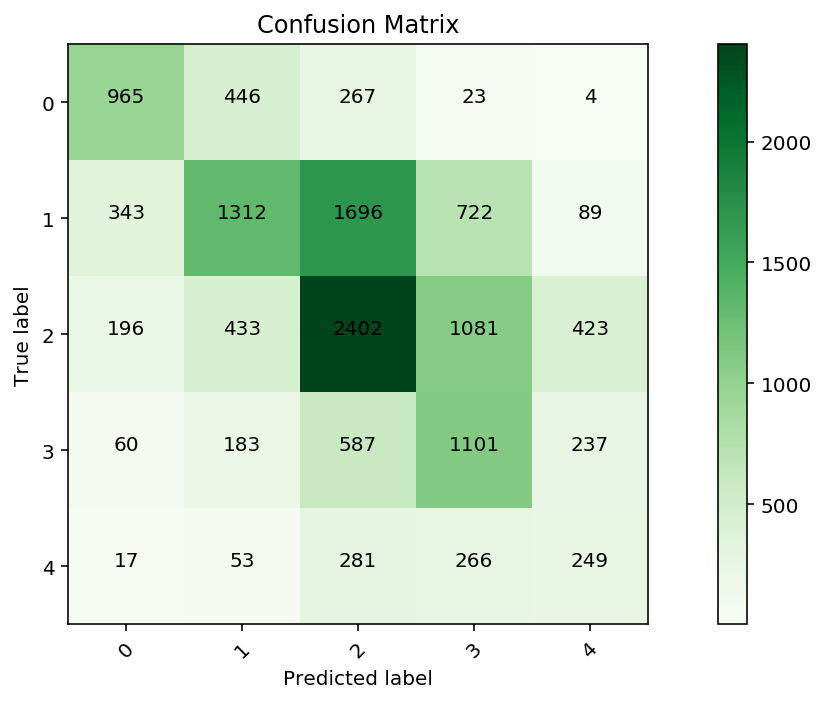

In [23]:
from utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()